# **Testing DefenseGAN on Image Classifiers**

* CS486: Robust Machine Learning 
* Drexel University - Spring 2023 
* Luke Ingram

In [1]:
import os 
import pickle
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import mse_loss
import torchvision.transforms as vt
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
from torch.utils.data import DataLoader


from models import Generator
from pytorch_cifar.models import VGG, MobileNetV2, ResNet18
from AdversarialDataset import AdversarialDataset

## **Loading our Models & Data**

In [9]:
GAN_FILE_PATH = os.path.join('models', 'checkpoints', 'gans', 'defensegan_128_v2.pth')
MODEL_SAVES_DIR = os.path.join('models', 'checkpoints', 'classifiers')
DEVICE = torch.device('cuda')

LATENT_VECTOR_SIZE = 128
BATCH_SIZE = 64

In [3]:
# Load CIFAR-10

mean, std = [-0.0541, -0.0127,  0.0265], [0.9868, 1.0000, 1.0029]

transforms = vt.Compose([
    vt.ToTensor(),
    vt.Normalize(mean, std)
])

cifar10_dataset = CIFAR10(root='./data', train=False, download=True, transform=transforms)
cifar10_loader = DataLoader(cifar10_dataset, batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified


In [4]:
labelType = b'label_names'

meta_file = os.path.join("data", "cifar-10-batches-py", "batches.meta")

with open(meta_file, 'rb') as f:
    meta_data = pickle.load(f, encoding='bytes')
    # Extract label names
    label_names = [label.decode('utf-8') for label in meta_data[labelType]]
    f.close()

print(*label_names[:11], '...', sep=', ')

airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck, ...


In [11]:
# Load Classifiers 
vgg16 = VGG('VGG16', num_classes=10)
vgg16.load_state_dict(torch.load(os.path.join(MODEL_SAVES_DIR, 'vgg16.pth')))
vgg16 = vgg16.to(DEVICE)
vgg16.eval()

mobilenet = MobileNetV2(num_classes=10)
mobilenet.load_state_dict(torch.load(os.path.join(MODEL_SAVES_DIR, 'mobilenetv2.pth')))
mobilenet = mobilenet.to(DEVICE)
mobilenet.eval()

resnet = ResNet18(num_classes=10)
resnet.load_state_dict(torch.load(os.path.join(MODEL_SAVES_DIR, 'resnet18.pth')))
resnet = resnet.to(DEVICE)
resnet.eval()


# Load Generator
generator = Generator(LATENT_VECTOR_SIZE, dim=128)
GAN_state_dict = torch.load(GAN_FILE_PATH)
generator.load_state_dict(GAN_state_dict.get('generator_state_dict'))
#generator.load_state_dict(torch.load(GAN_FILE_PATH))
generator = generator.to(DEVICE)
generator.eval()


Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=8192, bias=True)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Unflatten(dim=1, unflattened_size=(512, 4, 4))
    (4): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (11): Tanh()
  )
)

## **Constructing the Inference Pipeline**

Before we can use DefenseGAN we need to construct our inference pipeline:

![DefenseGAN PipeLine](notebook_media/defensegan_pipeline.png) 

More Specifically, the *Minimize* component: 

![DefenseGAN Minimize Component](notebook_media/defensegan_min_component.png)



This component projects the input image onto the range of the generator (i.e encoding the image data into a latent vector), using $L$ steps of GD. A full explanation can be found in the original [paper](https://arxiv.org/abs/1805.06605).

We implement this here:

In [6]:
L = 1000 # Number of gradient descent steps
R = 3 # Number of random restarts

In [7]:
def get_z_sets(
        model: nn.Module, 
        input_data: torch.Tensor, 
        lr: float = 0.1, 
        num_iterations: int = 200, 
        num_random_restarts: int = 10, 
    ) -> Tuple[torch.Tensor, torch.Tensor]:

    """
    Computes z vectors by optimizing them to minimize the reconstruction error 
    between the generator output and an input image.

    Args:
        model (nn.Module): The generator model.
        input_data (torch.Tensor): The input data (images).
        lr (float): Initial learning rate for SGD.
        reconstruction_loss_fn: The loss function for reconstruction.
        device (torch.device): The device to perform computation on.
        num_iterations (int): Number of iterations for gradient descent.
        num_random_restarts (int): Number of random restarts for z vector initialization.
        latent_vector_size (int): Size of the latent vector.
        global_step (int): Global step for learning rate adjustment.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: The original and reconstructed z vectors.
    """

    z_hats_recs = torch.Tensor(num_random_restarts, input_data.size(0), LATENT_VECTOR_SIZE)
    z_hats_orig = torch.Tensor(num_random_restarts, input_data.size(0), LATENT_VECTOR_SIZE)

    reconstruction_errors = []

    for idx in range(len(z_hats_recs)):
        z_hat = torch.randn(input_data.size(0), LATENT_VECTOR_SIZE).to(DEVICE)
        z_hat.requires_grad = True

        optimizer = optim.Adam([z_hat], lr=lr)
        scheduler = ReduceLROnPlateau(optimizer, 'min')

        z_hats_orig[idx] = z_hat.cpu().detach().clone()

        errors_per_restart = []
        
        for _ in range(num_iterations):
            optimizer.zero_grad()

            fake_image = model(z_hat).view(-1, input_data.size(1), input_data.size(2), input_data.size(3))
            reconstruct_loss = mse_loss(fake_image, input_data)
            reconstruct_loss.backward()

            optimizer.step()
            scheduler.step(reconstruct_loss)

            errors_per_restart.append(reconstruct_loss.item())

        z_hats_recs[idx] = z_hat.cpu().detach().clone()

        reconstruction_errors.append(errors_per_restart)

    return z_hats_recs, reconstruction_errors



def get_z_star(model: nn.Module, input_data: torch.Tensor, z_hats_recs: torch.Tensor) -> torch.Tensor:

    """
    Finds the z vector with the minimum reconstruction error.

    Args:
        model (nn.Module): The generator model.
        input_data (torch.Tensor): The input data (images).
        z_hats_recs (torch.Tensor): The reconstructed z vectors.
        reconstruction_loss_fn: The loss function for reconstruction.
        device (torch.device): The device to perform computation on.

    Returns:
        torch.Tensor: The z vector with the minimum reconstruction error.
    """

    reconstructions = torch.Tensor(len(z_hats_recs))

    for i in range(len(z_hats_recs)):
        z = model(z_hats_recs[i].to(DEVICE)).view(-1, input_data.size(1), input_data.size(2), input_data.size(3))
        reconstructions[i] = mse_loss(z, input_data).cpu().item()

    min_idx = torch.argmin(reconstructions)
    return z_hats_recs[min_idx]


def project_onto_generator(
        generator: nn.Module, 
        input_data: torch.Tensor, 
        num_iterations: int = 25, 
        random_restarts: int = 10, 
        lr: float = 0.1,
        verbose: bool = False
        ) -> torch.Tensor:
    z_sets, plot_data = get_z_sets(generator, input_data, lr, num_iterations, random_restarts) 
    best_z = get_z_star(generator, input_data, z_sets).to(DEVICE)
    
    out = generator(best_z)

    if verbose: 
        return out, plot_data

    return out, None

def plot_reconstruction_errors(reconstruction_errors):
    plt.figure(figsize=(10, 6))
    for idx, errors in enumerate(reconstruction_errors):
        iterations = list(range(1, len(errors) + 1))  # Create a list of iteration numbers
        plt.plot(iterations, errors, label=f'Restart {idx+1}')
    plt.title("Reconstruction Error over Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Reconstruction Error")
    plt.legend()
    plt.grid()
    plt.show()

Let's visualize this with a sample from our testing set.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


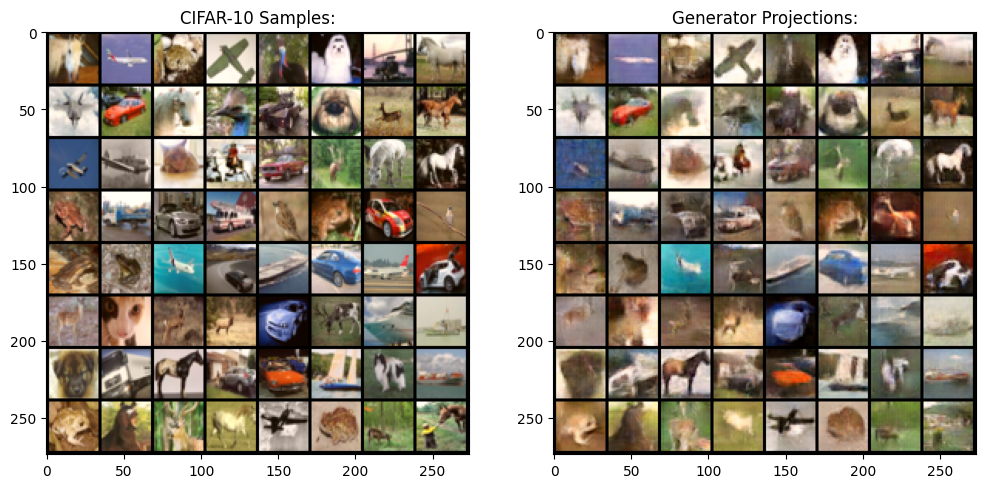

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

# Get one image and label from CIFAR-10
image, labels = next(iter(cifar10_loader))
image = image.to(DEVICE)

projected_img, plot_data = project_onto_generator(generator, image, L, R, lr=0.253, verbose=True)

ax1.imshow(np.transpose(make_grid(image.cpu()).numpy(), (1, 2, 0)))
ax1.set_title(f"CIFAR-10 Samples:")
ax2.imshow(np.transpose(make_grid(projected_img.cpu().detach()), (1, 2, 0)))
ax2.set_title(f"Generator Projections:")
plt.show()

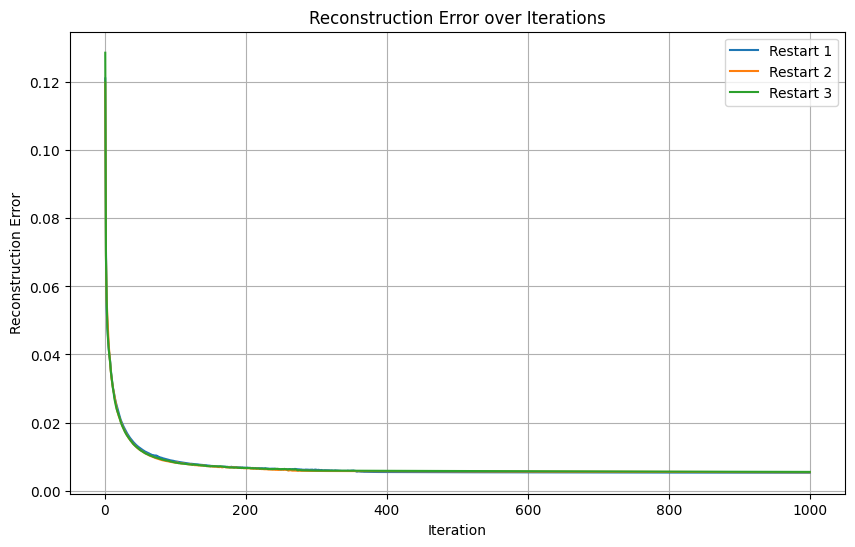

In [9]:
plot_reconstruction_errors(plot_data)

Projecting Adversarial Samples: 

In [17]:
DATA_SAVE_ROOT = os.path.join("data", "adversarial")

adv_transforms = vt.Compose([ 
    vt.Normalize(mean, std)
])

adv_dataset = AdversarialDataset(os.path.join(DATA_SAVE_ROOT, 'resnet18', 'linfty'), transform=adv_transforms)
adv_loader = DataLoader(adv_dataset, batch_size=BATCH_SIZE, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


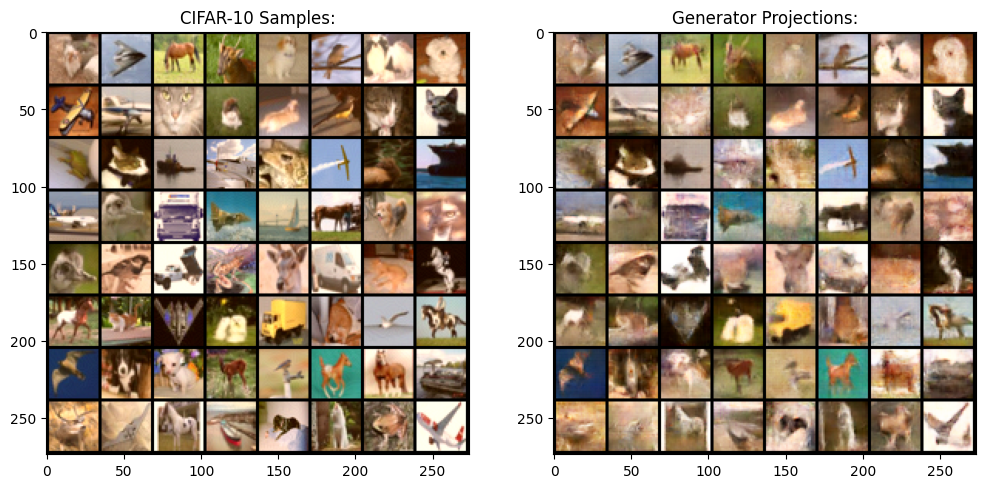

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

# Get one image and label from CIFAR-10
image, labels = next(iter(adv_loader))
image = image.to(DEVICE)

projected_img, plot_data = project_onto_generator(generator, image, L, R, lr=0.253, verbose=True)

ax1.imshow(np.transpose(make_grid(image.cpu()).numpy(), (1, 2, 0)))
ax1.set_title(f"CIFAR-10 Samples:")
ax2.imshow(np.transpose(make_grid(projected_img.cpu().detach()), (1, 2, 0)))
ax2.set_title(f"Generator Projections:")
plt.show()

The rest of our pipeline is straightforward:

In [15]:
def test_gan(generator: nn.Module, classifier: nn.Module, loader: DataLoader) -> torch.Tensor:

    sampleCnt = 0
    correctCnt = 0
    
    for _, (inputs, labels) in tqdm(enumerate(loader)):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        # (1 - 2) Minimize & Generate 
        projected_inputs, _ = project_onto_generator(generator, inputs, L, R)
        
        # (2) Classify 
        outputs = classifier(projected_inputs)
        _, preds = torch.max(outputs, 1)

        correctCnt += torch.sum(preds == labels)
        sampleCnt += inputs.size(0)

        del inputs, outputs
        torch.cuda.empty_cache()
    
    return (correctCnt.double().cpu() / sampleCnt)
    

## **Defending Classifiers with DefenseGAN**

#### **Control**

As a control, we run our clean testing data through our pipeline. 

In [14]:
# VGG16
print(f"Testing accruacy: {test_gan(generator, vgg16, cifar10_loader)}")

# MobileNetV2
print(f"Testing accruacy: {test_gan(generator, mobilenet, cifar10_loader)}")

# ResNet18
print(f"Testing accruacy: {test_gan(generator, resnet, cifar10_loader)}")

157it [1:20:03, 30.60s/it]


Testing accruacy: 0.5581


157it [58:22, 22.31s/it]


Testing accruacy: 0.4915


157it [37:43, 14.42s/it]

Testing accruacy: 0.5363


#### **FGSM**

In [14]:
def fetch_adv_loader(path: str, transforms: vt.transforms): 

    adv_dataset = AdversarialDataset(path, transform=transforms)
    adv_loader = DataLoader(adv_dataset, batch_size=BATCH_SIZE, shuffle=False)
    return adv_loader



In [18]:
# Load datasets & create dataloaders 

adv_loader_vgg = fetch_adv_loader(os.path.join(DATA_SAVE_ROOT, 'vgg16', 'fgsm'), transforms=adv_transforms)
adv_dataset_mobilenet = fetch_adv_loader(os.path.join(DATA_SAVE_ROOT, 'mobilenetv2', 'fgsm'), transforms=adv_transforms)
adv_loader_resnet = fetch_adv_loader(os.path.join(DATA_SAVE_ROOT, 'resnet18', 'fgsm'), transforms=adv_transforms)



# Inference (with DefenseGAN)
print(f"Testing accruacy: {test_gan(generator, vgg16, adv_loader_vgg)}")
print(f"Testing accruacy: {test_gan(generator, mobilenet, adv_dataset_mobilenet)}")
print(f"Testing accruacy: {test_gan(generator, resnet, adv_loader_resnet)}")

68it [17:20, 15.30s/it]


Testing accruacy: 0.38661453541858326


118it [30:20, 15.42s/it]


Testing accruacy: 0.4077605615150311


71it [18:05, 15.22s/it]

#### **$L_\infty$**

In [17]:
# Load datasets & create dataloaders 
adv_loader_vgg = fetch_adv_loader(os.path.join(DATA_SAVE_ROOT, 'vgg16', 'linfty'), transforms=adv_transforms)
adv_dataset_mobilenet = fetch_adv_loader(os.path.join(DATA_SAVE_ROOT, 'mobilenetv2', 'linfty'), transforms=adv_transforms)
adv_loader_resnet = fetch_adv_loader(os.path.join(DATA_SAVE_ROOT, 'resnet18', 'linfty'), transforms=adv_transforms)

# Inference (with DefenseGAN)
print(f"Testing accruacy: {test_gan(generator, vgg16, adv_loader_vgg)}")
print(f"Testing accruacy: {test_gan(generator, mobilenet, adv_dataset_mobilenet)}")
print(f"Testing accruacy: {test_gan(generator, resnet, adv_loader_resnet)}")

113it [27:27, 14.58s/it]


Testing accruacy: 0.4603946637020567


156it [37:54, 14.58s/it]


Testing accruacy: 0.4609280835676979


135it [32:06, 14.27s/it]

Testing accruacy: 0.480204937121565


## **Results**

Here are the tabulated results of DefenseGAN against two white-box attacks (FGSM & $L_\infty$).
| Model | No Attack | FGSM Attack | $L_{\infty}$ Attack |
| -----| ---------|  -----------| ---------------|
| VGG16 | 93.04% | 1.534% | 2.18% | 
| MobileNetV2 | 92.26% | 3.36% | 0.54% |
| ResNet18 | 94.73% | 2.56% |  1.11% | 
| VGG16 (With DefenseGAN) | 55.81% | 38.66% | 46% |
| MobileNetV2 (With DefenseGAN) | 49.15%  | 40.77% | 46% |
| ResNet18 (With DefenseGAN) | 53.63% |  |48% |
